In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load the data
data = pd.read_csv('Compiled.csv', parse_dates=['datetime'])
data.head()

,Unnamed: 0,index,load,pressure,cloud_cov,humid,temp,wind_dir,wind_sp,pressure_f,...,h21,h22,h23,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,datetime
0,0,0,1.031472e+06,1012.48000,2.125,79.333333,16.764386,285.25,6.25375,1011.0,...,0,0,0,0.000000,1.000000,1.0,6.120000e-17,-0.485302,-0.874347,2017-03-18 00:00:00
1,1,1,1.007206e+06,1011.61875,0.000,82.166667,15.729386,285.00,9.20500,1011.0,...,0,0,0,0.258819,0.965926,1.0,6.120000e-17,-0.485302,-0.874347,2017-03-18 01:00:00
2,2,2,9.861084e+05,1010.72000,2.125,81.666667,15.816886,316.00,11.28375,1011.0,...,0,0,0,0.500000,0.866025,1.0,6.120000e-17,-0.485302,-0.874347,2017-03-18 02:00:00
3,3,3,9.707610e+05,1011.37625,17.125,82.250000,15.919386,327.00,7.16875,1011.0,...,0,0,0,0.707107,0.707107,1.0,6.120000e-17,-0.485302,-0.874347,2017-03-18 03:00:00
4,4,4,9.622584e+05,1011.50000,18.625,82.333333,15.769386,282.25,0.78000,1011.0,...,0,0,0,0.866025,0.500000,1.0,6.120000e-17,-0.485302,-0.874347,2017-03-18 04:00:00


In [8]:
MAE = {
    'naive_forecast': [0 for i in range(0,51)],
    'seasonal_forecast_daily': [0 for i in range(0,51)],
    'seasonal_forecast_weekly': [0 for i in range(0,51)],
    'seasonal_forecast_yearly': [0 for i in range(0,51)],
    'random_walk_forecast': [0 for i in range(0,51)],
    'linear_regression': [0 for i in range(0,51)]
}

MSE = {
    'naive_forecast': [0 for i in range(0,51)],
    'seasonal_forecast_daily': [0 for i in range(0,51)],
    'seasonal_forecast_weekly': [0 for i in range(0,51)],
    'seasonal_forecast_yearly': [0 for i in range(0,51)],
    'random_walk_forecast': [0 for i in range(0,51)],
    'linear_regression': [0 for i in range(0,51)]
}

RMSE = {
    'naive_forecast': [0 for i in range(0,51)],
    'seasonal_forecast_daily': [0 for i in range(0,51)],
    'seasonal_forecast_weekly': [0 for i in range(0,51)],
    'seasonal_forecast_yearly': [0 for i in range(0,51)],
    'random_walk_forecast': [0 for i in range(0,51)],
    'linear_regression': [0 for i in range(0,51)]
}

forecasts = ['naive_forecast', 'seasonal_forecast_daily', 'seasonal_forecast_weekly', 
             'seasonal_forecast_yearly', 'random_walk_forecast', 'linear_regression']

exogenous_columns = ['pressure_f', 'cloud_cov_f', 'temp_f', 'wind_dir_f', 'wind_sp_f', 
                     'tue','wed','thu','fri','sat','sun',
                     'feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec',
                     'h1','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11','h12',
                     'h13','h14','h15','h16','h17','h18','h19','h20','h21','h22','h23']

initial_train_size=24*365
num_forecasts = int((len(data) - 365*24)/24 - 1)
step = 24


for f in tqdm(range(0, num_forecasts)):
    
    start_window = step*f
    end_window = initial_train_size + step*f
    
    train = data[start_window:end_window]
    test = data[end_window:end_window + 48]
    
    y_hat = test[['load']].copy()
    y_hat['naive_forecast'] = np.mean(train['load'][-24:])
    y_hat['seasonal_forecast_daily'] = [train['load'].iloc[-(i%24 + 1)] for i in range(47,-1,-1)]
    y_hat['seasonal_forecast_weekly'] = train['load'][-24*7:-24*7+48].values
    y_hat['seasonal_forecast_yearly'] = train['load'][-24*365:-24*365+48].values
    drift = (train['load'].iloc[-1]-train['load'].iloc[0])/(365*24-1)
    y_hat['random_walk_forecast'] = y_hat['naive_forecast']+[i*drift for i in range(1,49)]
    
 ######################################## INSERT FORECAST HERE ########################################   

    forecaster = ForecasterAutoreg(
                 regressor        = LinearRegression(),
                 lags             = [1, 2, 24, 25, 48, 49, 72, 73, 96, 97, 120, 121, 144, 145, 167, 168],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )

    forecaster.fit(y=train['load'], exog=train[exogenous_columns])
    
    y_hat['linear_regression'] = forecaster.predict(48, train['load'], test[exogenous_columns])
    
    ###################################################################################################
    
    
    for forecast in forecasts:
        abs_err = (abs(y_hat[forecast]-y_hat['load']))
        MAE[forecast][0:48] = np.add(MAE[forecast][0:48],abs_err/num_forecasts)
        MSE[forecast][0:48] = np.add(MSE[forecast][0:48],(abs_err**2)/num_forecasts)
        


100%|██████████████████████████████████████████████████████████████████████████████| 1034/1034 [02:38<00:00,  6.50it/s]


In [9]:
for forecast in forecasts:
    
    MAE[forecast][48] = np.mean(MAE[forecast][0:24])
    MAE[forecast][49] = np.mean(MAE[forecast][24:48])
    MAE[forecast][50] = np.mean(MAE[forecast][0:48])
    
    MSE[forecast][48] = np.mean(MSE[forecast][0:24])
    MSE[forecast][49] = np.mean(MSE[forecast][24:48])
    MSE[forecast][50] = np.mean(MSE[forecast][0:48])
    
    RMSE[forecast][0:48] = np.sqrt(MSE[forecast][0:48])
    RMSE[forecast][48] = np.mean(RMSE[forecast][0:24])
    RMSE[forecast][49] = np.mean(RMSE[forecast][24:48])
    RMSE[forecast][50] = np.mean(RMSE[forecast][0:48])

MAE_df = pd.DataFrame(MAE, index=['H'+str(i) for i in range(1,49)] + ['First 24 hours'] + ['Second 24 hours'] + ['Total'])
MSE_df = pd.DataFrame(MSE, index=['H'+str(i) for i in range(1,49)] + ['First 24 hours'] + ['Second 24 hours'] + ['Total'])
RMSE_df = pd.DataFrame(RMSE, index=['H'+str(i) for i in range(1,49)] + ['First 24 hours'] + ['Second 24 hours'] + ['Total'])

In [6]:
pd.options.display.float_format = '{:20,.2f}'.format

In [10]:
frames = [MAE_df.iloc[48:51], MSE_df.iloc[48:51], RMSE_df.iloc[48:51]]
pd.concat(frames, keys=["MAE", "MSE", "RMSE"])

naive_forecast  seasonal_forecast_daily  \
MAE  First 24 hours            110,416.19                52,404.88   
     Second 24 hours           119,957.74                69,349.50   
     Total                     115,186.96                60,877.19   
MSE  First 24 hours     18,269,754,296.34         8,012,680,198.53   
     Second 24 hours    21,078,915,285.68        11,990,721,144.81   
     Total              19,674,334,791.01        10,001,700,671.67   
RMSE First 24 hours            130,073.76                75,859.71   
     Second 24 hours           140,466.62                93,519.31   
     Total                     135,270.19                84,689.51   

                      seasonal_forecast_weekly  seasonal_forecast_yearly  \
MAE  First 24 hours                  36,491.29                100,620.60   
     Second 24 hours                 36,496.67                100,607.43   
     Total                           36,493.98                100,614.02   
MSE  First 24 hours           3,144,472,591.89         19,533,772,843.67   
     Second 24 hours          3,144,586,821.65         19,530,723,345.69   
     Total                    3,144,529,706.77         19,532,248,094.68   
RMSE First 24 hours                  53,162.08                128,654.89   
     Second 24 hours                 53,162.59                128,648.11   
     Total                           53,162.33                128,651.50   

                      random_walk_forecast    linear_regression  
MAE  First 24 hours             110,416.77            28,652.86  
     Second 24 hours            119,970.88            38,241.35  
     Total                      115,193.82            33,447.10  
MSE  First 24 hours      18,268,577,896.41     2,139,328,316.78  
     Second 24 hours     21,084,374,092.54     3,005,101,478.84  
     Total               19,676,475,994.48     2,572,214,897.81  
RMSE First 24 hours             130,074.56            42,067.44  
     Second 24 hours            140,498.11            53,308.79  
     Total                      135,286.33            47,688.11

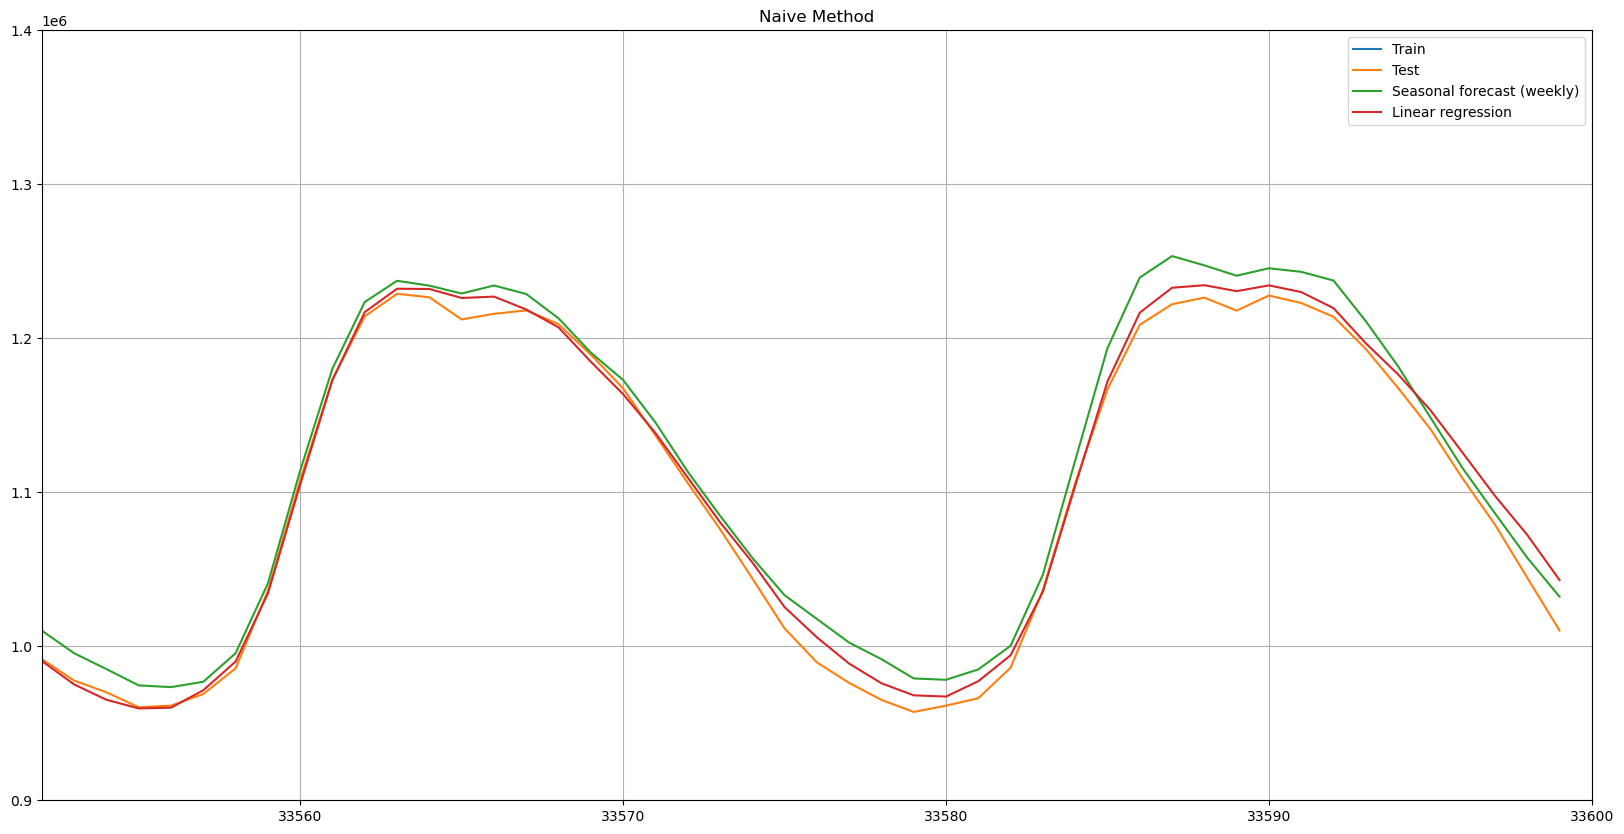

In [12]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(train['load'], label='Train')
plt.plot(test['load'], label='Test')
#plt.plot(y_hat['naive_forecast'], label='Naive forecast')
#plt.plot(y_hat['seasonal_forecast_daily'], label='Seasonal forecast (daily)')
plt.plot(y_hat['seasonal_forecast_weekly'], label='Seasonal forecast (weekly)')
#plt.plot(y_hat['seasonal_forecast_yearly'], label='Seasonal forecast (yearly)')
#plt.plot(y_hat['random_walk_forecast'], label='Random walk with drift forecast')
plt.plot(y_hat['linear_regression'], label='Linear regression')
plt.legend(loc='best')
plt.title('Naive Method')
plt.xlim(len(data)-2*24,len(data))
plt.ylim(900000,1400000)
plt.show()